In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from category_encoders.sum_coding import SumEncoder
import psycopg2

C:\Users\ArvindYekkirala\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ArvindYekkirala\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\ArvindYekkirala\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)
C:\Users\ArvindYekkirala\AppData\Roaming\Python\Python37\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
database = 'legacy_warehouse'
user = 'fivetran'
password = 'n3wP455!'
host = 'paropostrpt.cgltfgjn7lnm.us-west-2.rds.amazonaws.com'
port = '5432'

In [4]:
#Paro Salesforce Opp table
conn = psycopg2.connect(database=database, user = user, password = password, host = host, port =port)
cur = conn.cursor()
cur.execute('select * from paro_salesforce."Opportunity"')
rows = cur.fetchall()
colnames = [desc[0] for desc in cur.description]
cur.close()
paro_saleforce_opp_table = pd.DataFrame(rows, columns=colnames)

In [5]:
#Paro Salesforce Channel Mapping
conn = psycopg2.connect(database=database, user = user, password = password, host = host, port =port)
cur = conn.cursor()
cur.execute('select * from adaptiveai.channel_mapping')
rows = cur.fetchall()
colnames = [desc[0] for desc in cur.description]
cur.close()
channel_mapping = pd.DataFrame(rows, columns=colnames)
channel_mapping=channel_mapping.replace('\ufeff','',regex=True)

In [6]:
#Month level new pr

#Projects signed in a given month

conn = psycopg2.connect(database=database, user = user, password = password, host = host, port =port)
cur = conn.cursor()
cur.execute('''select distinct project_id,date_trunc('Month',sow_signed_date_calculated) as record_date,project_fsv
from 
(select distinct proposal_id,sow_signed_date_calculated 
from adaptiveai.proposal_dim where sow_signed_date_calculated is not null) A
inner join 
(select distinct proposal_id,project_id,project_fsv from adaptiveai.project_dim
where busy_flag_new <> 1) B on A.proposal_id = B.proposal_id''')
rows = cur.fetchall()
colnames = [desc[0] for desc in cur.description]
cur.close()
projects_signed_in_a_month = pd.DataFrame(rows, columns=colnames)
projects_signed_in_a_month['record_date'] = projects_signed_in_a_month['record_date'].dt.date
projects_signed_in_a_month['record_date'] = pd.to_datetime(projects_signed_in_a_month['record_date'])


#PR in that month

conn = psycopg2.connect(database=database, user = user, password = password, host = host, port =port)
cur = conn.cursor()
cur.execute('''select distinct project_id,record_date,fsv as pr from adaptiveai.project_month_dim''')
rows = cur.fetchall()
colnames = [desc[0] for desc in cur.description]
cur.close()
project_month_pr = pd.DataFrame(rows, columns=colnames)
project_month_pr['record_date'] = pd.to_datetime(project_month_pr['record_date'])

#project_signed_month_pr = projects_signed_in_a_month.merge(project_month_pr,on=['project_id','record_date'],how='left')
#month_level_signed_pr = pd.DataFrame(project_signed_month_pr.groupby('record_date')['pr'].sum()).reset_index()
month_level_signed_pr = pd.DataFrame(projects_signed_in_a_month.groupby('record_date')['project_fsv'].sum()).reset_index()

In [7]:
# Read CAC values 
cac_values = pd.read_excel('cac.xlsx')

In [8]:
#Dropping Referral for now 
cac_values.drop('Referral / WOM',axis=1,inplace=True)

In [9]:
#Calcualte total costs using CAC for data after 2021
#cac_adjust = pd.read_excel('cac_adjustment_2021.xlsx')

#l=[]
#for date in cac_adjust['record_date'].unique():
#    temp_1 = cac_values.loc[cac_values['record_date']==date]
#    temp_2 = cac_adjust.loc[cac_adjust['record_date']==date]
#    for col in temp_1.columns.tolist():
#        if col == 'record_date':
#            continue
#        temp_1[col] = temp_1[col]*temp_2.loc[temp_2['channel']==col].reset_index()['count'][0]
#    l.append(temp_1)
#cac_after_2021 = pd.concat(l)

#cac_values = cac_values.loc[cac_values['record_date']<'2021-01-01']
#cac_values = pd.concat([cac_values,cac_after_2021])

In [10]:
cac_values

,record_date,Inbound - SEO / Content,Online Advertising,Outbound Sales,Partnerships
0,2017-01-01,3849.410000,18695.830000,8951.170000,880.660000
1,2017-02-01,6927.160000,18760.160000,9184.300000,724.210000
2,2017-03-01,5867.320000,18872.240000,12128.880000,659.320000
3,2017-04-01,5976.850000,26445.540000,12991.950000,3925.890000
4,2017-05-01,9150.210000,30311.330000,18538.510000,3271.620000
5,2017-06-01,9059.320000,26249.670000,18463.550000,3314.440000
6,2017-07-01,9036.510000,29786.960000,23076.440000,3362.520000
7,2017-08-01,11978.860000,32354.420000,16038.760000,3284.450000
8,2017-09-01,9202.170000,36558.390000,18163.870000,3342.790000
9,2017-10-01,9806.030000,55862.110000,22368.940000,5098.620000


In [11]:
#Generate marketting spend in the last 1 month 2 month 3 month 
df_1= cac_values.copy()
df_1.columns = ['record_date','Inbound - SEO / Content Current','Online Advertising Current','Outbound Sales Current','Partnerships Current']
df_1[['Inbound - SEO / Content 1 Month','Online Advertising 1 Month','Outbound Sales 1 Month','Partnerships 1 Month']] = df_1[['Inbound - SEO / Content Current','Online Advertising Current','Outbound Sales Current','Partnerships Current']].shift(1)
df_1[['Inbound - SEO / Content 2 Month','Online Advertising 2 Month','Outbound Sales 2 Month','Partnerships 2 Month']] = df_1[['Inbound - SEO / Content Current','Online Advertising Current','Outbound Sales Current','Partnerships Current']].shift(2)
df_1[['Inbound - SEO / Content 3 Month','Online Advertising 3 Month','Outbound Sales 3 Month','Partnerships 3 Month']] = df_1[['Inbound - SEO / Content Current','Online Advertising Current','Outbound Sales Current','Partnerships Current']].shift(3)
df_1[['Inbound - SEO / Content 4 Month','Online Advertising 4 Month','Outbound Sales 4 Month','Partnerships 4 Month']] = df_1[['Inbound - SEO / Content Current','Online Advertising Current','Outbound Sales Current','Partnerships Current']].shift(4)
df_1[['Inbound - SEO / Content 5 Month','Online Advertising 5 Month','Outbound Sales 5 Month','Partnerships 5 Month']] = df_1[['Inbound - SEO / Content Current','Online Advertising Current','Outbound Sales Current','Partnerships Current']].shift(5)
df_1['overall_cac'] = df_1['Inbound - SEO / Content Current'] + df_1['Online Advertising Current'] + df_1['Outbound Sales Current'] + df_1['Partnerships Current']
df_1['overall_cac_1_month'] = df_1['Inbound - SEO / Content 1 Month'] + df_1['Online Advertising 1 Month'] + df_1['Outbound Sales 1 Month'] + df_1['Partnerships 1 Month']
df_1['overall_cac_2_month'] = df_1['Inbound - SEO / Content 2 Month'] + df_1['Online Advertising 2 Month'] + df_1['Outbound Sales 2 Month'] + df_1['Partnerships 2 Month']
df_1['overall_cac_3_month'] = df_1['Inbound - SEO / Content 3 Month'] + df_1['Online Advertising 3 Month'] + df_1['Outbound Sales 3 Month'] + df_1['Partnerships 3 Month']
df_1['overall_cac_4_month'] = df_1['Inbound - SEO / Content 4 Month'] + df_1['Online Advertising 4 Month'] + df_1['Outbound Sales 4 Month'] + df_1['Partnerships 4 Month']
df_1['overall_cac_5_month'] = df_1['Inbound - SEO / Content 5 Month'] + df_1['Online Advertising 5 Month'] + df_1['Outbound Sales 5 Month'] + df_1['Partnerships 5 Month']
df_1.dropna(inplace=True)

In [12]:
df_1['Inbound - SEO / Content last 3 Month'] = df_1['Inbound - SEO / Content 1 Month'] + df_1['Inbound - SEO / Content 2 Month'] + df_1['Inbound - SEO / Content 3 Month']
df_1['Online Advertising last 3 Month'] = df_1['Online Advertising 1 Month'] + df_1['Online Advertising 2 Month'] + df_1['Online Advertising 3 Month']
df_1['Outbound Sales last 3 Month'] = df_1['Outbound Sales 1 Month'] + df_1['Outbound Sales 2 Month'] + df_1['Outbound Sales 3 Month']
df_1['Partnerships last 3 Month'] = df_1['Partnerships 1 Month'] + df_1['Partnerships 2 Month'] + df_1['Partnerships 3 Month']
df_1['overall_cac_last_3_month'] = df_1['overall_cac_1_month'] + df_1['overall_cac_2_month'] + df_1['overall_cac_3_month']

In [13]:
#remove opps with no lead source data 
display(paro_saleforce_opp_table.shape)
paro_saleforce_opp_table = paro_saleforce_opp_table.loc[~(paro_saleforce_opp_table['LeadSource'].isna())]
display(paro_saleforce_opp_table.shape)

(16508, 142)

(16122, 142)

In [14]:
#No of opps in current month 
opp_data = paro_saleforce_opp_table[['CreatedDate','Opp_18_Digit_ID__c']].drop_duplicates()
opp_data['record_date'] = opp_data['CreatedDate'].to_numpy().astype('datetime64[M]')
opp_data_agg = pd.DataFrame(opp_data.groupby('record_date')['Opp_18_Digit_ID__c'].nunique()).reset_index()
opp_data_agg.columns = ['record_date','opps_in_current_month']
df_2 = df_1.merge(opp_data_agg,on='record_date',how='left')
df_2['opps_last_1_month'] = df_2['opps_in_current_month'].shift(1)
df_2['opps_last_2_month'] = df_2['opps_in_current_month'].shift(2)
df_2['opps_last_3_month'] = df_2['opps_in_current_month'].shift(3)

C:\Users\ArvindYekkirala\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
#subset only from 2019 to 2021 oct 
df_2= df_2.loc[(df_2['record_date']>='2019-01-01') & (df_2['record_date']<='2021-10-01')]

In [16]:
#Merge month level pr
df_2 = df_2.merge(month_level_signed_pr,on='record_date',how='left')

In [17]:
#No. of opps per channel in a given month 
lead_source_opp_data = paro_saleforce_opp_table[['CreatedDate','Opp_18_Digit_ID__c','LeadSource']].drop_duplicates()
lead_source_opp_data.columns = ['created_date','salesforce_opp_id','lead_source']
lead_source_opp_data_1 = lead_source_opp_data.merge(channel_mapping,on='lead_source',how='left')
lead_source_opp_data_1['record_date'] = lead_source_opp_data_1['created_date'].to_numpy().astype('datetime64[M]')


channel_date_df=pd.DataFrame(lead_source_opp_data_1.groupby(['record_date','channel'])['salesforce_opp_id'].nunique()).reset_index()
channel_date_df_1=pd.pivot_table(channel_date_df, values = ['salesforce_opp_id'], index=['record_date'], columns = 'channel').reset_index()
channel_date_df_1.columns = ['record_date','inbound_opps','online_advertising_opps','outbound_opps','partnership_opps']



channel_date_df_1[['inbound_opps_1_month','online_advertising_1_month','outbound_opps_1_month','partnership_opps_1_month']] = channel_date_df_1[['inbound_opps','online_advertising_opps','outbound_opps','partnership_opps']].shift(1)
channel_date_df_1[['inbound_opps_2_month','online_advertising_2_month','outbound_opps_2_month','partnership_opps_2_month']] = channel_date_df_1[['inbound_opps','online_advertising_opps','outbound_opps','partnership_opps']].shift(2)
channel_date_df_1[['inbound_opps_3_month','online_advertising_3_month','outbound_opps_3_month','partnership_opps_3_month']] = channel_date_df_1[['inbound_opps','online_advertising_opps','outbound_opps','partnership_opps']].shift(3)
channel_date_df_1 = channel_date_df_1.loc[(channel_date_df_1['record_date']>='2019-01-01') & (channel_date_df_1['record_date']<='2021-10-01')]
channel_date_df_1.reset_index(inplace=True,drop=True)

#Mix 
channel_date_df_1.fillna(0.1,inplace=True)
df_3 = df_2.merge(channel_date_df_1,on='record_date',how='left')

# channel compositional
channel_cols = ['opps_in_current_month','inbound_opps', 'online_advertising_opps', 'outbound_opps', 'partnership_opps']
channel_comp = df_3[channel_cols]
channel_comp = channel_comp.divide(channel_comp['opps_in_current_month'], axis=0)
base_channel = 'partnership_opps'
channel_cv = channel_comp.divide(channel_comp[base_channel], axis=0)
channel_cv =np.log(channel_cv)
channel_cv.drop('opps_in_current_month',axis=1,inplace=True)
df_4 = pd.concat([df_3.drop(['inbound_opps','online_advertising_opps','outbound_opps','partnership_opps'],axis=1),channel_cv],axis=1)

# channel lag 1 compositional
channel_cols = ['opps_last_1_month','inbound_opps_1_month', 'online_advertising_1_month', 'outbound_opps_1_month', 'partnership_opps_1_month']
channel_comp = df_3[channel_cols]
channel_comp = channel_comp.divide(channel_comp['opps_last_1_month'], axis=0)
base_channel = 'partnership_opps_1_month'
channel_cv = channel_comp.divide(channel_comp[base_channel], axis=0)
channel_cv =np.log(channel_cv)
channel_cv.drop('opps_last_1_month',axis=1,inplace=True)
df_5 = pd.concat([df_4.drop(['inbound_opps_1_month','online_advertising_1_month','outbound_opps_1_month','partnership_opps_1_month'],axis=1),channel_cv],axis=1)

# channel lag 2 compositional
channel_cols = ['opps_last_2_month','inbound_opps_2_month', 'online_advertising_2_month', 'outbound_opps_2_month', 'partnership_opps_2_month']
channel_comp = df_3[channel_cols]
channel_comp = channel_comp.divide(channel_comp['opps_last_2_month'], axis=0)
base_channel = 'partnership_opps_2_month'
channel_cv = channel_comp.divide(channel_comp[base_channel], axis=0)
channel_cv =np.log(channel_cv)
channel_cv.drop('opps_last_2_month',axis=1,inplace=True)
df_6 = pd.concat([df_5.drop(['inbound_opps_2_month','online_advertising_2_month','outbound_opps_2_month','partnership_opps_2_month'],axis=1),channel_cv],axis=1)

# channel lag 3 compositional
channel_cols = ['opps_last_3_month','inbound_opps_3_month', 'online_advertising_3_month', 'outbound_opps_3_month', 'partnership_opps_3_month']
channel_comp = df_3[channel_cols]
channel_comp = channel_comp.divide(channel_comp['opps_last_3_month'], axis=0)
base_channel = 'partnership_opps_3_month'
channel_cv = channel_comp.divide(channel_comp[base_channel], axis=0)
channel_cv =np.log(channel_cv)
channel_cv.drop('opps_last_3_month',axis=1,inplace=True)
df_7 = pd.concat([df_6.drop(['inbound_opps_3_month','online_advertising_3_month','outbound_opps_3_month','partnership_opps_3_month'],axis=1),channel_cv],axis=1)

C:\Users\ArvindYekkirala\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  """


In [18]:
#Mix of CAC in a given month 

 
# channel compositional
channel_cols = ['overall_cac','Inbound - SEO / Content Current', 'Online Advertising Current', 'Outbound Sales Current', 'Partnerships Current']
channel_comp = df_7[channel_cols]
channel_comp = channel_comp.divide(channel_comp['overall_cac'], axis=0)
base_channel = 'Partnerships Current'
channel_cv = channel_comp.divide(channel_comp[base_channel], axis=0)
channel_cv =np.log(channel_cv)
channel_cv.drop('overall_cac',axis=1,inplace=True)
df_8 = pd.concat([df_7.drop(['Inbound - SEO / Content Current','Online Advertising Current','Outbound Sales Current','Partnerships Current'],axis=1),channel_cv],axis=1)

# channel lag 1 compositional
channel_cols = ['overall_cac_1_month','Inbound - SEO / Content 1 Month', 'Online Advertising 1 Month', 'Outbound Sales 1 Month', 'Partnerships 1 Month']
channel_comp = df_8[channel_cols]
channel_comp = channel_comp.divide(channel_comp['overall_cac_1_month'], axis=0)
base_channel = 'Partnerships 1 Month'
channel_cv = channel_comp.divide(channel_comp[base_channel], axis=0)
channel_cv =np.log(channel_cv)
channel_cv.drop('overall_cac_1_month',axis=1,inplace=True)
df_9 = pd.concat([df_8.drop(['Inbound - SEO / Content 1 Month','Online Advertising 1 Month','Outbound Sales 1 Month','Partnerships 1 Month'],axis=1),channel_cv],axis=1)

# channel lag 2 compositional
channel_cols = ['overall_cac_2_month','Inbound - SEO / Content 2 Month', 'Online Advertising 2 Month', 'Outbound Sales 2 Month', 'Partnerships 2 Month']
channel_comp = df_9[channel_cols]
channel_comp = channel_comp.divide(channel_comp['overall_cac_2_month'], axis=0)
base_channel = 'Partnerships 2 Month'
channel_cv = channel_comp.divide(channel_comp[base_channel], axis=0)
channel_cv =np.log(channel_cv)
channel_cv.drop('overall_cac_2_month',axis=1,inplace=True)
df_10 = pd.concat([df_9.drop(['Inbound - SEO / Content 2 Month','Online Advertising 2 Month','Outbound Sales 2 Month','Partnerships 2 Month'],axis=1),channel_cv],axis=1)

# channel lag 3 compositional
channel_cols = ['overall_cac_3_month','Inbound - SEO / Content 3 Month', 'Online Advertising 3 Month', 'Outbound Sales 3 Month', 'Partnerships 3 Month']
channel_comp = df_10[channel_cols]
channel_comp = channel_comp.divide(channel_comp['overall_cac_3_month'], axis=0)
base_channel = 'Partnerships 3 Month'
channel_cv = channel_comp.divide(channel_comp[base_channel], axis=0)
channel_cv =np.log(channel_cv)
channel_cv.drop('overall_cac_3_month',axis=1,inplace=True)
df_11 = pd.concat([df_10.drop(['Inbound - SEO / Content 3 Month','Online Advertising 3 Month','Outbound Sales 3 Month','Partnerships 3 Month'],axis=1),channel_cv],axis=1)

# channel lag 4 compositional
channel_cols = ['overall_cac_4_month','Inbound - SEO / Content 4 Month', 'Online Advertising 4 Month', 'Outbound Sales 4 Month', 'Partnerships 4 Month']
channel_comp = df_11[channel_cols]
channel_comp = channel_comp.divide(channel_comp['overall_cac_4_month'], axis=0)
base_channel = 'Partnerships 4 Month'
channel_cv = channel_comp.divide(channel_comp[base_channel], axis=0)
channel_cv =np.log(channel_cv)
channel_cv.drop('overall_cac_4_month',axis=1,inplace=True)
df_12 = pd.concat([df_11.drop(['Inbound - SEO / Content 4 Month','Online Advertising 4 Month','Outbound Sales 4 Month','Partnerships 4 Month'],axis=1),channel_cv],axis=1)

# channel lag 5 compositional
channel_cols = ['overall_cac_5_month','Inbound - SEO / Content 5 Month', 'Online Advertising 5 Month', 'Outbound Sales 5 Month', 'Partnerships 5 Month']
channel_comp = df_12[channel_cols]
channel_comp = channel_comp.divide(channel_comp['overall_cac_5_month'], axis=0)
base_channel = 'Partnerships 5 Month'
channel_cv = channel_comp.divide(channel_comp[base_channel], axis=0)
channel_cv =np.log(channel_cv)
channel_cv.drop('overall_cac_5_month',axis=1,inplace=True)
df_13 = pd.concat([df_12.drop(['Inbound - SEO / Content 5 Month','Online Advertising 5 Month','Outbound Sales 5 Month','Partnerships 5 Month'],axis=1),channel_cv],axis=1)

# channel last 3 months compositional
channel_cols = ['overall_cac_last_3_month','Inbound - SEO / Content last 3 Month', 'Online Advertising last 3 Month', 'Outbound Sales last 3 Month', 'Partnerships last 3 Month']
channel_comp = df_12[channel_cols]
channel_comp = channel_comp.divide(channel_comp['overall_cac_last_3_month'], axis=0)
base_channel = 'Partnerships last 3 Month'
channel_cv = channel_comp.divide(channel_comp[base_channel], axis=0)
channel_cv =np.log(channel_cv)
channel_cv.drop('overall_cac_last_3_month',axis=1,inplace=True)
df_14 = pd.concat([df_13.drop(['Inbound - SEO / Content last 3 Month','Online Advertising last 3 Month','Outbound Sales last 3 Month','Partnerships last 3 Month'],axis=1),channel_cv],axis=1)

In [19]:
#inbound = 389968 
#online_adv = 1333499 
#outbound = 711288 
#partnerships = 92846

#total = 2527601

#channel_comp = [389968,1333499,711288,92846]
#channel_comp = channel_comp.divide(channel_comp['overall_cac_5_month'], axis=0)
#channel_mix = [inbound,online_advertising,outbound,partnerships]
#base_channel = partnerships
#channel_mix = [np.log(val/base_channel) for val in channel_mix]

In [20]:
#channel_comp = [389968/2527601,1333499/2527601,711288/2527601,92846/2527601]

In [21]:
#channel_comp

In [22]:
#Check 
['inbound_opps','online_advertising_opps','outbound_opps','partnership_opps']
temp = channel_date_df_1[['inbound_opps','online_advertising_opps','outbound_opps','partnership_opps']].sum(axis=1)

In [23]:
df_11['opps_in_current_month'] - temp

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
dtype: float64

In [24]:
#Check 
temp = channel_date_df_1[['inbound_opps_1_month','online_advertising_1_month','outbound_opps_1_month','partnership_opps_1_month']].sum(axis=1)

In [25]:
df_11['opps_last_1_month'] - temp

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
dtype: float64

In [26]:
#Check 
temp = channel_date_df_1[['inbound_opps_2_month','online_advertising_2_month','outbound_opps_2_month','partnership_opps_2_month']].sum(axis=1)

In [27]:
df_11['opps_last_2_month'] - temp

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
dtype: float64

In [28]:
#Check 
temp = channel_date_df_1[['inbound_opps_3_month','online_advertising_3_month','outbound_opps_3_month','partnership_opps_3_month']].sum(axis=1)

In [29]:
df_11['opps_last_3_month'] - temp

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
dtype: float64

In [30]:
#Check 
['Inbound - SEO / Content Current','Online Advertising Current', 'Outbound Sales Current', 'Partnerships Current']
temp = df_7[['Inbound - SEO / Content Current','Online Advertising Current', 'Outbound Sales Current', 'Partnerships Current']].sum(axis=1)

In [31]:
df_7['overall_cac'] - temp

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
dtype: float64

In [32]:
#Check 
['Inbound - SEO / Content 1 Month', 'Online Advertising 1 Month', 'Outbound Sales 1 Month', 'Partnerships 1 Month']
temp = df_7[['Inbound - SEO / Content 1 Month', 'Online Advertising 1 Month', 'Outbound Sales 1 Month', 'Partnerships 1 Month']].sum(axis=1)

In [33]:
df_7['overall_cac_1_month'] - temp

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
dtype: float64

In [34]:
#Check 
['Inbound - SEO / Content 2 Month', 'Online Advertising 2 Month', 'Outbound Sales 2 Month', 'Partnerships 2 Month']
temp = df_7[['Inbound - SEO / Content 2 Month', 'Online Advertising 2 Month', 'Outbound Sales 2 Month', 'Partnerships 2 Month']].sum(axis=1)

In [35]:
df_7['overall_cac_2_month'] - temp

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
dtype: float64

In [36]:
#Check 
['Inbound - SEO / Content 3 Month', 'Online Advertising 3 Month', 'Outbound Sales 3 Month', 'Partnerships 3 Month']
temp = df_7[['Inbound - SEO / Content 3 Month', 'Online Advertising 3 Month', 'Outbound Sales 3 Month', 'Partnerships 3 Month']].sum(axis=1)

In [37]:
df_7['overall_cac_3_month'] - temp

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
dtype: float64

In [38]:
#Check 
['Inbound - SEO / Content 4 Month', 'Online Advertising 4 Month', 'Outbound Sales 4 Month', 'Partnerships 4 Month']
temp = df_7[['Inbound - SEO / Content 4 Month', 'Online Advertising 4 Month', 'Outbound Sales 4 Month', 'Partnerships 4 Month']].sum(axis=1)

In [39]:
df_7['overall_cac_4_month'] - temp

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
dtype: float64

In [40]:
#Check 
['Inbound - SEO / Content 5 Month', 'Online Advertising 5 Month', 'Outbound Sales 5 Month', 'Partnerships 5 Month']
temp = df_7[['Inbound - SEO / Content 5 Month', 'Online Advertising 5 Month', 'Outbound Sales 5 Month', 'Partnerships 5 Month']].sum(axis=1)

In [41]:
df_7['overall_cac_5_month'] - temp

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
11    0.0
12    0.0
13    0.0
14    0.0
15    0.0
16    0.0
17    0.0
18    0.0
19    0.0
20    0.0
21    0.0
22    0.0
23    0.0
24    0.0
25    0.0
26    0.0
27    0.0
28    0.0
29    0.0
30    0.0
31    0.0
32    0.0
33    0.0
dtype: float64

In [42]:
#Check 
['Inbound - SEO / Content last 3 Month', 'Online Advertising last 3 Month', 'Outbound Sales last 3 Month', 'Partnerships last 3 Month']
temp = df_7[['Inbound - SEO / Content last 3 Month', 'Online Advertising last 3 Month', 'Outbound Sales last 3 Month', 'Partnerships last 3 Month']].sum(axis=1)

In [43]:
df_7['overall_cac_last_3_month'] - temp

0     0.000000e+00
1    -1.164153e-10
2     2.328306e-10
3     2.328306e-10
4    -2.328306e-10
5     0.000000e+00
6     0.000000e+00
7     0.000000e+00
8     0.000000e+00
9     0.000000e+00
10    0.000000e+00
11    0.000000e+00
12    0.000000e+00
13    2.328306e-10
14    2.328306e-10
15    0.000000e+00
16    0.000000e+00
17    0.000000e+00
18    2.328306e-10
19    2.328306e-10
20    2.328306e-10
21    2.328306e-10
22    0.000000e+00
23    0.000000e+00
24    2.328306e-10
25    0.000000e+00
26    4.656613e-10
27    0.000000e+00
28    0.000000e+00
29    4.656613e-10
30    0.000000e+00
31    0.000000e+00
32    4.656613e-10
33   -4.656613e-10
dtype: float64

In [44]:
#No. of salesrep 

sales_rep_data = paro_saleforce_opp_table[['CreatedDate','Account_Owner__c']].drop_duplicates()
sales_rep_data['record_date'] = sales_rep_data['CreatedDate'].to_numpy().astype('datetime64[M]')
sales_rep_agg = pd.DataFrame(sales_rep_data.groupby('record_date')['Account_Owner__c'].nunique()).reset_index()
sales_rep_agg.columns = ['record_date','no_of_sales_rep']
df_15 = df_14.merge(sales_rep_agg,on='record_date',how='left')

C:\Users\ArvindYekkirala\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  after removing the cwd from sys.path.


In [45]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    error = np.abs((y_true - y_pred) / y_true)
    return np.mean(error[np.isfinite(error)])

In [46]:
ds = df_15.drop(['record_date','partnership_opps','partnership_opps_1_month','partnership_opps_2_month','partnership_opps_3_month','inbound_opps','online_advertising_opps','outbound_opps','Inbound - SEO / Content Current','Online Advertising Current','Outbound Sales Current','Partnerships Current','opps_last_1_month','opps_last_2_month','opps_last_3_month','inbound_opps_1_month','online_advertising_1_month','outbound_opps_1_month','partnership_opps_1_month','inbound_opps_2_month','online_advertising_2_month','outbound_opps_2_month','partnership_opps_2_month','inbound_opps_3_month','online_advertising_3_month','outbound_opps_3_month','partnership_opps_3_month','Partnerships Current','Partnerships 1 Month','Partnerships 2 Month','Partnerships 3 Month','Partnerships 4 Month','Partnerships 5 Month','overall_cac_4_month','overall_cac_5_month','overall_cac','Inbound - SEO / Content 5 Month', 'Online Advertising 5 Month', 'Outbound Sales 5 Month', 'Partnerships 5 Month','Inbound - SEO / Content 4 Month', 'Online Advertising 4 Month', 'Outbound Sales 4 Month', 'Partnerships 4 Month','Partnerships last 3 Month','Inbound - SEO / Content 1 Month','Online Advertising 1 Month','Online Advertising 1 Month','Outbound Sales 1 Month','Inbound - SEO / Content 2 Month','Online Advertising 2 Month','Outbound Sales 2 Month','Inbound - SEO / Content 3 Month','Online Advertising 3 Month','Outbound Sales 3 Month','overall_cac_last_3_month','no_of_sales_rep','overall_cac_1_month','overall_cac_2_month','opps_in_current_month'],axis = 1)

In [49]:
ds['project_fsv'] = ds['project_fsv'].astype(int)

In [50]:
y=np.log(ds['project_fsv'])
#y = ds['pr']
x = ds.drop(['project_fsv'],axis=1)
x = sm.add_constant(x)
#model_conv = sm.GLM(y,x.astype(float)).fit(method='Newton')
model_ = sm.OLS(y,x.astype(float))
#model_ = sm.GLM(y, x, family = sm.families.Poisson(link=sm.families.links.log()))
model_conv = model_.fit()
y_pred = np.exp(model_conv.predict(x.astype(float)))
#y_pred = model_conv.predict(x)

In [51]:
x

,const,overall_cac_3_month,Inbound - SEO / Content last 3 Month,Online Advertising last 3 Month,Outbound Sales last 3 Month
0,1.0,254569.300,0.770471,2.592951,1.668476
1,1.0,304780.770,0.697496,2.627335,1.644950
2,1.0,357706.170,0.603579,2.490258,1.483676
3,1.0,379339.330,0.515975,2.458734,1.439672
4,1.0,384105.430,0.303808,2.377946,1.343501
5,1.0,434976.390,0.157530,2.477207,1.452941
6,1.0,437624.930,-0.085207,2.258576,1.248009
7,1.0,468535.910,0.042308,2.289445,1.259774
8,1.0,490264.630,0.053571,2.237154,1.192714
9,1.0,515963.140,0.192673,2.406553,1.316344


In [52]:
model_conv.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            project_fsv   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     27.05
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           2.03e-09
Time:                        16:36:26   Log-Likelihood:                 6.4668
No. Observations:                  34   AIC:                            -2.934
Df Residuals:                      29   BIC:                             4.698
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
const                                   13.4378      0.862     15.594      0.000      11.675      15.200
overall_cac_3_month                   1.524e-06   3.56e-07      4.286      0.000    7.97e-07    2.25e-06
Inbound - SEO / Content last 3 Month     0.3040      0.172      1.764      0.088      -0.049       0.656
Online Advertising last 3 Month         -0.0319      0.746     -0.043      0.966      -1.558       1.494
Outbound Sales last 3 Month             -0.0286      0.671     -0.043      0.966      -1.400       1.343
==============================================================================
Omnibus:                        0.731   Durbin-Watson:                   2.461
Prob(Omnibus):                  0.694   Jarque-Bera (JB):                0.142
Skew:                          -0.103   Prob(JB):                        0.931
Kurtosis:                       3.241   Cond. No.                     1.94e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.94e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [55]:
df=pd.DataFrame()
df['Actuals'] = pd.Series(ds['project_fsv'])
df['Predictions'] = y_pred
df['Predictions'] = df['Predictions'].astype(int)
df['Actuals'] = df['Actuals'].astype(int)

In [56]:
df

,Actuals,Predictions
0,1272486,1120907
1,864252,1183015
2,1014846,1257557
3,1172896,1268430
4,1120788,1204278
5,1328003,1236963
6,1481889,1168528
7,1082958,1271628
8,1339173,1323694
9,1478285,1423247


In [57]:
import seaborn as sns

C:\Users\ArvindYekkirala\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\ArvindYekkirala\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='Actuals'>

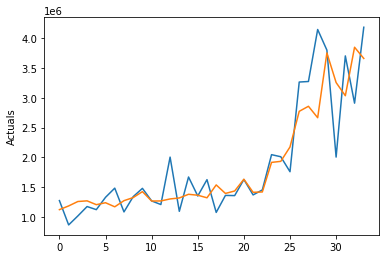

In [58]:
sns.lineplot(df.index,df['Actuals'])
sns.lineplot(df.index,df['Predictions'])

In [60]:
mean_absolute_percentage_error(y_pred,df['Actuals'])

0.15036520919211957

In [61]:
import pickle
filename = 'mkt_spend_model_new_fsv_signed.sav'
pickle.dump(model_conv, open(filename, 'wb'))

# Simulation

In [127]:
sim_df_1 = df_14.drop(['Inbound - SEO / Content 2 Month','Online Advertising 2 Month','Outbound Sales 2 Month','Partnerships 2 Month'],axis=1)
sim_df_2 = sim_df_1.merge(df_1[['record_date','Inbound - SEO / Content 2 Month','Online Advertising 2 Month','Outbound Sales 2 Month','Partnerships 2 Month']],on='record_date',how='left')
sim_df_3 = sim_df_2.copy()

In [128]:
def func_comp(df,over_all_col,cols,base_var):
    cols.append(over_all_col)
    comp = sim_df_3[cols]
    comp = comp.divide(comp[over_all_col], axis=0)
    cv = comp.divide(comp[base_var], axis=0)
    cv =np.log(cv)
    cv.drop(over_all_col,axis=1,inplace=True) 
    df = pd.concat([df.drop(cv.columns.tolist(),axis=1),cv],axis=1)
    return df

In [129]:
l=[]
multiplier=100
cols_to_increase = ['Inbound - SEO / Content 2 Month']
cols_to_decrease = ['Online Advertising 2 Month','Outbound Sales 2 Month','Partnerships 2 Month']
sim_df_3 = sim_df_3.loc[sim_df_3['record_date']=='2021-10-01']
for i in range(1,2000):
    sim_df_3[cols_to_increase] = sim_df_3[cols_to_increase]  + 1*multiplier
    sum_cac = sim_df_3[cols_to_decrease].sum()/sim_df_3[cols_to_decrease].sum().sum()
    for col in cols_to_decrease:
        sim_df_3[col] = sim_df_3[col] -(sum_cac[col])*multiplier
        #sim_df_3['Outbound Sales 3 Month'] = sim_df_3['Outbound Sales 3 Month'] -(1/3)*multiplier
        #sim_df_3['Partnerships 3 Month'] = sim_df_3['Partnerships 3 Month'] -(1/3)*multiplier
    over_all_col = 'overall_cac_2_month'
    cols = ['Inbound - SEO / Content 2 Month', 'Online Advertising 2 Month', 'Outbound Sales 2 Month', 'Partnerships 2 Month']
    base_var = 'Partnerships 2 Month'
    sim_df_4 = func_comp(sim_df_3,over_all_col,cols,base_var)
    ds = sim_df_4.drop(['partnership_opps','partnership_opps_1_month','partnership_opps_2_month',
                        'partnership_opps_3_month','inbound_opps','online_advertising_opps',
                        'outbound_opps','Inbound - SEO / Content Current','Online Advertising Current',
                        'Outbound Sales Current','Partnerships Current','opps_last_1_month','opps_last_2_month',
                        'opps_last_3_month','inbound_opps_1_month','online_advertising_1_month','outbound_opps_1_month',
                        'partnership_opps_1_month','inbound_opps_2_month','online_advertising_2_month','outbound_opps_2_month',
                        'partnership_opps_2_month','inbound_opps_3_month','online_advertising_3_month','outbound_opps_3_month',
                        'partnership_opps_3_month','Partnerships Current','Partnerships 1 Month','Partnerships 2 Month',
                        'Partnerships 3 Month','Partnerships 4 Month','Partnerships 5 Month','overall_cac_1_month',
                        'overall_cac_2_month','overall_cac_3_month','overall_cac_4_month','overall_cac_5_month','overall_cac'],axis = 1)
    ds_1 = ds.copy()
    ds_1.drop(['record_date','opps_in_current_month'],axis=1,inplace=True)
    ds_1['const'] = 1
    ds_1 = ds_1[x.columns.tolist()]
    ds_1.reset_index(drop=True,inplace=True)
    y_pred = model_conv.predict(ds_1)[0]
    df=pd.DataFrame()
    df['inbound_increase'] = pd.Series(i*multiplier)
    df['no_of_opps'] = y_pred
    df['no_of_opps'] = df['no_of_opps'].astype(int)
    l.append(df)
sim_result = pd.concat(l)
sim_result.reset_index(drop=True,inplace=True)

C:\Users\ArvindYekkirala\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='inbound_increase', ylabel='no_of_opps'>

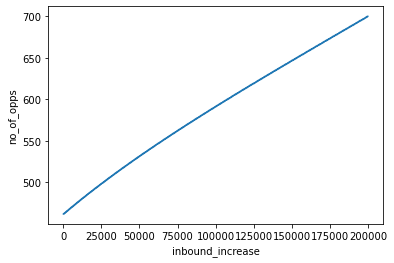

In [130]:
import matplotlib.pyplot as plt
sns.lineplot(sim_result['inbound_increase'],sim_result['no_of_opps'])


In [138]:
l=[]
multiplier=100
cols_to_increase = ['Outbound Sales 3 Month']
cols_to_decrease = ['Online Advertising 3 Month','Partnerships 3 Month','Inbound - SEO / Content 3 Month']
sim_df_3 = sim_df_3.loc[sim_df_3['record_date']=='2020-12-01']
for i in range(1,1000):
    sim_df_3[cols_to_increase] = sim_df_3[cols_to_increase]  + 1*multiplier
    sum_cac = sim_df_3[cols_to_decrease].sum()/sim_df_3[cols_to_decrease].sum().sum()
    for col in cols_to_decrease:
        sim_df_3[col] = sim_df_3[col] -(sum_cac[col])*multiplier
        #sim_df_3['Outbound Sales 3 Month'] = sim_df_3['Outbound Sales 3 Month'] -(1/3)*multiplier
        #sim_df_3['Partnerships 3 Month'] = sim_df_3['Partnerships 3 Month'] -(1/3)*multiplier
    over_all_col = 'overall_cac_3_month'
    cols = ['Inbound - SEO / Content 3 Month', 'Online Advertising 3 Month', 'Outbound Sales 3 Month', 'Partnerships 3 Month']
    base_var = 'Partnerships 3 Month'
    sim_df_4 = func_comp(sim_df_3,over_all_col,cols,base_var)
    ds = sim_df_4.drop(['partnership_opps','partnership_opps_1_month','partnership_opps_2_month',
                        'partnership_opps_3_month','inbound_opps','online_advertising_opps',
                        'outbound_opps','Inbound - SEO / Content Current','Online Advertising Current',
                        'Outbound Sales Current','Partnerships Current','opps_last_1_month','opps_last_2_month',
                        'opps_last_3_month','inbound_opps_1_month','online_advertising_1_month','outbound_opps_1_month',
                        'partnership_opps_1_month','inbound_opps_2_month','online_advertising_2_month','outbound_opps_2_month',
                        'partnership_opps_2_month','inbound_opps_3_month','online_advertising_3_month','outbound_opps_3_month',
                        'partnership_opps_3_month','Partnerships Current','Partnerships 1 Month','Partnerships 2 Month',
                        'Partnerships 3 Month','Partnerships 4 Month','Partnerships 5 Month','overall_cac_1_month',
                        'overall_cac_2_month','overall_cac_3_month','overall_cac_4_month','overall_cac_5_month','overall_cac'],axis = 1)
    ds_1 = ds.copy()
    ds_1.drop(['record_date','opps_in_current_month'],axis=1,inplace=True)
    ds_1['const'] = 1
    ds_1 = ds_1[x.columns.tolist()]
    ds_1.reset_index(drop=True,inplace=True)
    y_pred = model_conv.predict(ds_1)[0]
    df=pd.DataFrame()
    df['inbound_increase'] = pd.Series(i*multiplier)
    df['no_of_opps'] = y_pred
    df['no_of_opps'] = df['no_of_opps'].astype(int)
    l.append(df)
sim_result = pd.concat(l)
sim_result.reset_index(drop=True,inplace=True)

In [139]:
sim_result

,inbound_increase,no_of_opps
0,100,404
1,200,404
2,300,404
3,400,403
4,500,403
5,600,403
6,700,403
7,800,403
8,900,403
9,1000,403


C:\Users\ArvindYekkirala\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='inbound_increase', ylabel='no_of_opps'>

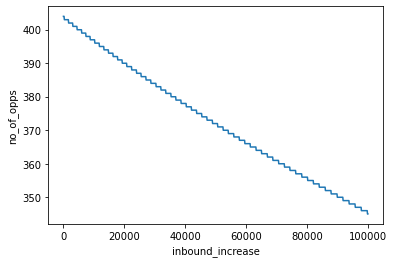

In [141]:
import matplotlib.pyplot as plt
sns.lineplot(sim_result['inbound_increase'],sim_result['no_of_opps'])


In [69]:
sim_df_1 = df_14.drop(['Inbound - SEO / Content 2 Month','Online Advertising 2 Month','Outbound Sales 2 Month','Partnerships 2 Month'],axis=1)
sim_df_2 = sim_df_1.merge(df_1[['record_date','Inbound - SEO / Content 2 Month','Online Advertising 2 Month','Outbound Sales 2 Month','Partnerships 2 Month']],on='record_date',how='left')
sim_df_3 = sim_df_2.copy()

In [70]:
l=[]
for i in range(1,1000):
    sim_df_3['Inbound - SEO / Content 2 Month'] = sim_df_3['Inbound - SEO / Content 2 Month'] + 1
    sim_df_3['Online Advertising 2 Month'] = sim_df_3['Online Advertising 2 Month'] -(1/3)
    sim_df_3['Outbound Sales 2 Month'] = sim_df_3['Outbound Sales 2 Month'] -(1/3)
    sim_df_3['Partnerships 2 Month'] = sim_df_3['Partnerships 2 Month'] -(1/3)
    over_all_col = 'overall_cac_2_month'
    cols = ['Inbound - SEO / Content 2 Month', 'Online Advertising 2 Month', 'Outbound Sales 2 Month', 'Partnerships 2 Month']
    base_var = 'Partnerships 2 Month'
    sim_df_4 = func_comp(sim_df_3,over_all_col,cols,base_var)
    ds = sim_df_4.drop(['partnership_opps','partnership_opps_1_month','partnership_opps_2_month','partnership_opps_3_month','inbound_opps','online_advertising_opps','outbound_opps','Inbound - SEO / Content Current','Online Advertising Current','Outbound Sales Current','Partnerships Current','opps_last_1_month','opps_last_2_month','opps_last_3_month','inbound_opps_1_month','online_advertising_1_month','outbound_opps_1_month','partnership_opps_1_month','inbound_opps_2_month','online_advertising_2_month','outbound_opps_2_month','partnership_opps_2_month','inbound_opps_3_month','online_advertising_3_month','outbound_opps_3_month','partnership_opps_3_month','Partnerships Current','Partnerships 1 Month','Partnerships 2 Month','Partnerships 3 Month','Partnerships 4 Month','Partnerships 5 Month','overall_cac_1_month','overall_cac_2_month','overall_cac_3_month','overall_cac_4_month','overall_cac_5_month','overall_cac'],axis = 1)
    ds_1 = ds.loc[ds['record_date']=='2021-10-01']
    ds_1.drop(['record_date','opps_in_current_month'],axis=1,inplace=True)
    ds_1['const'] = 1
    ds_1 = ds_1[x.columns.tolist()]
    ds_1.reset_index(drop=True,inplace=True)
    y_pred = model_conv.predict(ds_1)[0]
    df=pd.DataFrame()
    df['inbound_increase'] = pd.Series(i)
    df['no_of_opps'] = y_pred
    df['no_of_opps'] = df['no_of_opps'].astype(int)
    l.append(df)
sim_result = pd.concat(l)
sim_result['no_of_opps'] = sim_result['no_of_opps'].astype(int)

C:\Users\ArvindYekkirala\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\ArvindYekkirala\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [71]:
sim_result

,inbound_increase,no_of_opps
0,1,497
0,2,497
0,3,497
0,4,497
0,5,497
0,6,497
0,7,497
0,8,497
0,9,497
0,10,497


C:\Users\ArvindYekkirala\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='no_of_opps', ylabel='inbound_increase'>

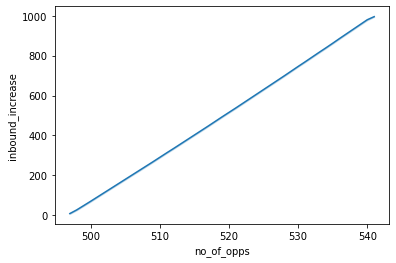

In [72]:
sns.lineplot(sim_result['no_of_opps'],sim_result['inbound_increase'])